<a href="https://colab.research.google.com/github/mikgroup/extreme_mri/blob/master/colab-demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extreme MRI Demo

This Colab notebook is a demo for [Extreme MRI: Large-Scale Volumetric Dynamic Imaging from Continuous Non-Gated Acquisitions](https://arxiv.org/abs/1909.13482).

# Setup

By default, this colab notebook should have a GPU runtime environment. To check this, go to **Runtime > Change runtime type** and see if **GPU** is selected as **Hardware accelerator**.

To setup, we will install [SigPy](http://sigpy.readthedocs.io) and clone the extreme_MRI github repo. The reconstruction also depends on [CuPy](https://cupy.chainer.org) for GPU functionalities, which is already installed on Google Colab.

In [1]:
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
!pip install sigpy h5py
! git clone https://github.com/mikgroup/extreme_mri
% cd extreme_mri


     \ 716kB 3.9MB/s
  Created wheel for tqdm: filename=tqdm-4.28.1-py2.py3-none-any.whl size=47867 sha256=0c10754fdc855bc98f6e0b6dc7cf66bd8236a4c603223b9b253801681fa71848
  Stored in directory: /tmp/pip-ephem-wheel-cache-u5d9bi5d/wheels/41/18/ee/d5dd158441b27965855b1bbae03fa2d8a91fe645c01b419896
Successfully built tqdm
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


     |████████████████████████████████| 92kB 3.2MB/s 
Cloning into 'extreme_mri'...
remote: Enumerating objects: 218, done.
remote: Counting objects: 100% (218/218), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 425 (delta 136), reused 151 (delta 77), pack-reused 207
Receiving objects: 100% (425/425), 762.73 KiB | 7.40 MiB/s, done.
Resolving deltas: 100% (266/266), done.
/content/extreme_mri


In [0]:
import numpy as np
import sigpy as sp
import sigpy.mri as mr
import sigpy.plot as pl

from download_dataset import download_dce_dataset
from gridding_recon import gridding_recon
from multi_scale_low_rank_recon import MultiScaleLowRankRecon

# Set GPU 0 as computing device
device = 0

# Download and Load dataset

Now, let's download and load the DCE dataset. The dataset is hosted on Zenodo: https://zenodo.org/record/3647820, and corresponds to the second DCE dataset described in the paper.

The `download_dce_dataset()` function will download the datasets if it cannot find them under `data/dce/`. It takes around 8 minutes to download the datasets.

In [4]:
download_dce_dataset()
ksp = np.load('data/dce/ksp.npy')
coord = np.load('data/dce/coord.npy')
dcf = np.load('data/dce/dcf.npy')

# (Optional) Speed up reconstruction by cropping k-space

To speed up the demo, we will crop the k-space data along readout to reconstruct images with lower spatial resolution

Simply comment out this part if you would like to perform the full-resolution reconstruction.

In [0]:
num_ro = 150  # number of readout points
ksp = ksp[:, :, :num_ro]
coord = coord[:, :num_ro]
dcf = dcf[:, :num_ro]

# Gridding reconstruction

Let's first do a gridding reconstruction to see what the image looks like.

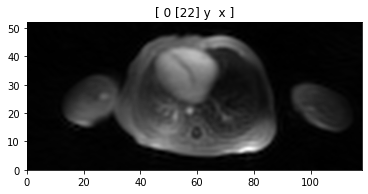

In [6]:
grd = gridding_recon(ksp, coord, dcf, device=device)

#Plot
pl.ImagePlot(grd, interpolation='lanczos')

# Generate Sensitivity Maps

We will need to estimate the sensitivity maps to incorporate multi-channel data. 

For this demo, we will use [JSENSE](https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.21245), which has a fast implementation in SigPy.

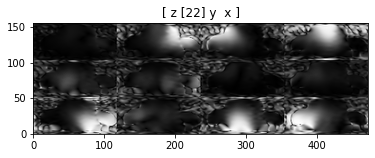

In [7]:
mps = mr.app.JsenseRecon(ksp, coord=coord, weights=dcf, device=device).run()

# Plot
pl.ImagePlot(mps, z=0, interpolation='lanczos')

# Multi-scale Low Rank Reconstruction

The following runs the multi-scale low rank reconstruction with 20 frames.

In this implementation, there is an initialization phase using the power iteration to initialize the singular vectors. Then, the reconstruction will run stochastic gradient method with 90 epochs.

As a reference, the low resolution reconstruction with 20 frames took about 8 minutes.

In [8]:
T = 20
lamda = 1e-8
img = MultiScaleLowRankRecon(ksp, coord, dcf, mps, T, lamda, device=device).run()



Reconstruction diverged. Restart with alpha=7.02.


# Plot

The returned image is stored in a compressed multi-scale low rank representation, and NOT a numpy array. This is useful when the underlying image is huge.

The compressed image can be indexed like a numpy array, and will adaptively reconstruct the indexed slice. In particular, it can be viewed directly using `pl.ImagePlot`. You can also speed up the slicing with the desired computing device using `img.use_device(device)`.

For the low resolution reconstruction, the memory usage is reasonable, so we can expand it completely. To obtain a numpy array from the compressed representation, you can do `img = img[:]`.
    


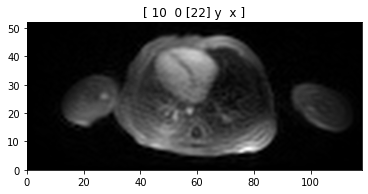

In [9]:
img = img[:]
pl.ImagePlot(img, interpolation='lanczos')